In [73]:
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.preprocessing
import sklearn.metrics
import seaborn as sns

import torch
import torch.nn.functional as F

import json

### Variability explained by verbs

In [90]:
properties_list = ['awareness',
       'change_of_location', 'change_of_state', 'changes_possession',
       'created', 'destroyed', 'existed_after', 'existed_before',
       'existed_during', 'exists_as_physical', 'instigation',
       'location_of_event', 'makes_physical_contact', 'manipulated_by_another',
       'predicate_changed_argument', 'sentient', 'stationary', 'volition']

roles_wide = pd.read_csv("decomp_pb_modified_sentences.csv", na_filter=False)[["Sentence.ID", "Roleset", "Gram.Func"] + properties_list]
roles_wide["verb"] = roles_wide["Roleset"].apply(lambda x: x.split(".")[0])

roles_wide.head()

,Sentence.ID,Roleset,Gram.Func,awareness,change_of_location,change_of_state,changes_possession,created,destroyed,existed_after,...,exists_as_physical,instigation,location_of_event,makes_physical_contact,manipulated_by_another,predicate_changed_argument,sentient,stationary,volition,verb
0,0003_21,impose.01,other,1,1,4,1,1,1,5,...,1,1,1,1,1,5,1,1,1,impose
1,0003_21,impose.01,subj,5,1,3,1,1,1,5,...,1,5,1,1,1,3,1,1,5,impose
2,0003_21,impose.01,obj,1,1,3,1,5,1,5,...,1,1,1,1,5,5,1,1,1,impose
3,0003_25,dump.01,subj,5,3,3,1,1,1,5,...,5,5,1,5,1,1,5,3,5,dump
4,0003_25,dump.01,obj,1,5,5,3,1,5,1,...,5,1,1,5,5,5,1,1,1,dump


In [91]:
prp_labels = roles_wide[properties_list].to_numpy()
roleset_features = (roles_wide["Roleset"] + roles_wide["Gram.Func"]).to_numpy()
verb_features = (roles_wide["verb"] + roles_wide["Gram.Func"]).to_numpy()


def make_valid(features, prp_labels, min_occurences=5):
    ordinal_encoder = sklearn.preprocessing.OrdinalEncoder()
    features = ordinal_encoder.fit_transform(features.reshape(-1, 1))

    # discard features with <5 occurrences
    feature_counts = np.unique(features, return_counts=True)
    valid_features = feature_counts[0][np.argwhere(feature_counts[1] >= min_occurences)]
    print("valid rolesets:", len(valid_features))
    valid_idx = np.argwhere(np.isin(features, valid_features))[:,0]
    print("valid samples:", len(valid_idx))

    prp_labels_valid = prp_labels[valid_idx]
    features_valid = features[valid_idx]
    return features_valid, prp_labels_valid, valid_features

In [92]:
# https://peterstatistics.com/CrashCourse/3-TwoVarUnpair/NomOrd/NomOrd3c.html
# https://meth.psychopen.eu/index.php/meth/article/view/7745/7745.html

def test_variability_explained(features, labels, k, n):
    variability = []

    # 1-5 scale
    data = np.concatenate([features, labels], axis=1).astype(int)
    df_by_features = pd.DataFrame(
        data, columns=["features"] + properties_list
        ).pivot_table(index="features", aggfunc=list).reset_index()

    for prp in properties_list:
        samples = df_by_features[prp].tolist()

        h, p = scipy.stats.kruskal(*samples)
        eta_squared = (h - (k - 1))/(n - (k - 1))
        eps_squared = (h - k + 1)/(n - k)

        variability.append({
            "scale": "5-class",
            "proto-role property": prp,
            "kruskal-wallis H": h,
            "p-value": p,
            "eta_squared": eta_squared,
            "eps_squared": eps_squared
        })

    # binary scale
    data = np.concatenate([features, (labels > 3).astype(int)], axis=1).astype(int)
    df_by_features = pd.DataFrame(
        data, columns=["features"] + properties_list
        ).pivot_table(index="features", aggfunc=list).reset_index()

    for prp in properties_list:
        samples = df_by_features[prp].tolist()

        h, p = scipy.stats.kruskal(*samples)
        eta_squared = (h - (k - 1))/(n - (k - 1))
        eps_squared = (h - k + 1)/(n - k)

        variability.append({
            "scale": "binary",
            "proto-role property": prp,
            "kruskal-wallis H": h,
            "p-value": p,
            "eta_squared": eta_squared,
            "eps_squared": eps_squared
        })

    # 3 classes
    data = np.concatenate([features, np.clip(labels, 2, 4)], axis=1).astype(int)
    df_by_features = pd.DataFrame(
        data, columns=["features"] + properties_list
        ).pivot_table(index="features", aggfunc=list).reset_index()

    for prp in properties_list:
        samples = df_by_features[prp].tolist()

        h, p = scipy.stats.kruskal(*samples)
        eta_squared = (h - (k - 1))/(n - (k - 1))
        eps_squared = (h - k + 1)/(n - k)

        variability.append({
            "scale": "3-class",
            "proto-role property": prp,
            "kruskal-wallis H": h,
            "p-value": p,
            "eta_squared": eta_squared,
            "eps_squared": eps_squared
        })

    return pd.DataFrame(variability)

In [93]:
roleset_features_valid, prp_labels_valid, valid_rolesets = make_valid(roleset_features, prp_labels, min_occurences=6)

k = len(valid_rolesets)
n = len(prp_labels_valid)

roleset_df = test_variability_explained(roleset_features_valid, prp_labels_valid, k, n)
roleset_df["features"] = "roleset"

valid rolesets: 559
valid samples: 4862


In [94]:
verb_features_valid, prp_labels_valid, valid_verbs = make_valid(verb_features, prp_labels, min_occurences=6)

k = len(valid_verbs)
n = len(verb_features_valid)

verb_df = test_variability_explained(verb_features_valid, prp_labels_valid, k, n)
verb_df["features"] = "verb"

valid rolesets: 541
valid samples: 5736


### Variability When Accounting for Word Sense

In [95]:
disambiguated = pd.read_csv("../wordnet/disambiguated_sentences.csv").drop("Unnamed: 0", axis=1).set_index("Sentence.ID")
disambiguated.head()

,Sentence,Sentence.Disambiguated,disambiguated_dict
Sentence.ID,,,
0003_21,"In July , the Environmental Protection Agency ...","In July|july%1:28:00:: , the Environmental Pro...","{'July': 'july.n.01', 'Protection': 'protectio..."
0003_25,Workers dumped large burlap sacks of the impor...,Workers|worker%1:18:00:: dumped|dump%2:40:00::...,"{'Workers': 'worker.n.01', 'dumped': 'dump.v.0..."
0003_29,It has no bearing on our work force today .,It has|have%2:40:00:: no bearing|bearing%1:24:...,"{'has': 'have.v.01', 'bearing': 'bearing.n.01'..."
0003_3,Although preliminary findings were reported *-...,Although preliminary|preliminary%3:00:00:explo...,"{'preliminary': 'preliminary.s.01', 'findings'..."
0003_9,Dr. Talcott led a team of researchers from the...,Dr.|dr.%1:18:00:: Talcott led|lead%2:38:01:: a...,"{'Dr.': 'doctor.n.01', 'led': 'lead.v.01', 'te..."


In [96]:
roles_wide = pd.read_csv("decomp_pb_modified_sentences.csv", na_filter=False).drop("Unnamed: 0", axis=1)

def get_verb_sense(row):
    predicate = row["Predicate"]
    sid = row["Sentence.ID"]
    d = disambiguated.loc[sid]["disambiguated_dict"]
    # replace single with double quotes so json can parse
    d = d.replace(" '", ' "').replace("':", '":').replace("',", '",').replace("{'", '{"').replace("'}", '"}')
    try:
        d = json.loads(d)
    except:
        print(d)
    if predicate in d:
        return d[predicate]
    else:
        print(predicate, d)
        print(disambiguated.loc[sid]["Sentence.Disambiguated"])
        return np.nan

roles_wide["verb_sense"] = roles_wide.apply(get_verb_sense, axis=1)
roles_wide.dropna(subset="verb_sense", inplace=True)
roles_wide.head()

sense {'active': 'active.a.05', 'suspension': 'suspension.n.05', 'systems': 'system.n.01', 'electronically': 'electronically.r.01', 'road': 'road.n.01', 'conditions': 'weather.n.01', 'adjust': 'adjust.v.01', 'car': 'car.n.01', 'ride': 'ride.n.02'}
These `` active|active%3:00:01:: suspension|suspension%1:06:00:: systems|system%1:06:00:: '' electronically|electronically%4:02:00:: sense road|road%1:06:00:: conditions|conditions%1:19:00:: and adjust|adjust%2:30:00:: a car|car%1:06:00:: 's ride|ride%1:06:00:: . 

sense {'active': 'active.a.05', 'suspension': 'suspension.n.05', 'systems': 'system.n.01', 'electronically': 'electronically.r.01', 'road': 'road.n.01', 'conditions': 'weather.n.01', 'adjust': 'adjust.v.01', 'car': 'car.n.01', 'ride': 'ride.n.02'}
These `` active|active%3:00:01:: suspension|suspension%1:06:00:: systems|system%1:06:00:: '' electronically|electronically%4:02:00:: sense road|road%1:06:00:: conditions|conditions%1:19:00:: and adjust|adjust%2:30:00:: a car|car%1:06:00::

,Sentence.ID,Roleset,Pred.Token,Arg.Pos,Gram.Func,Split,awareness,change_of_location,change_of_state,changes_possession,...,predicate_changed_argument,sentient,stationary,volition,Sentence,Arg.Phrase,Arg.Stripped,Sentence.Stripped,Predicate,verb_sense
0,0003_21,impose.01,7,11:1,other,train,1,1,4,1,...,5,1,1,1,"In July , the Environmental Protection Agency ...",on virtually all uses of asbestos,on all uses,"In July , the Environmental Protection Agency ...",imposed,inflict.v.01
1,0003_21,impose.01,7,3:1,subj,train,5,1,3,1,...,3,1,1,5,"In July , the Environmental Protection Agency ...",the Environmental Protection Agency,the Environmental Protection Agency,"In July , the Environmental Protection Agency ...",imposed,inflict.v.01
2,0003_21,impose.01,7,8:1,obj,test,1,1,3,1,...,5,1,1,1,"In July , the Environmental Protection Agency ...",a gradual ban,a ban,"In July , the Environmental Protection Agency ...",imposed,inflict.v.01
3,0003_25,dump.01,1,0:1,subj,train,5,3,3,1,...,1,5,3,5,Workers dumped large burlap sacks of the impor...,Workers,Workers,"Workers dumped burlap sacks into a huge bin , ...",dumped,dump.v.01
4,0003_25,dump.01,1,2:2,obj,train,1,5,5,3,...,5,1,1,1,Workers dumped large burlap sacks of the impor...,large burlap sacks of the imported material,burlap sacks,"Workers dumped burlap sacks into a huge bin , ...",dumped,dump.v.01


In [98]:
verb_sense_features = (roles_wide["verb_sense"] + roles_wide["Gram.Func"]).to_numpy()
prp_labels = roles_wide[properties_list].to_numpy()

verb_sense_features_valid, prp_labels_valid, valid_verb_senses = make_valid(
    verb_sense_features, prp_labels, min_occurences=6)

k = len(valid_verb_senses)
n = len(prp_labels_valid)

word_sense_df = test_variability_explained(verb_sense_features_valid, prp_labels_valid, k, n)
word_sense_df["features"] = "word_sense"

valid rolesets: 451
valid samples: 4237


In [88]:
verb_sense_features = (roles_wide["verb_sense"] + roles_wide["Gram.Func"]).to_numpy()
prp_labels = roles_wide[properties_list].to_numpy()

for m in range(0, 23):
    verb_sense_features_valid, prp_labels_valid, valid_verb_senses = make_valid(
        verb_sense_features, prp_labels, min_occurences=m)

    k = len(valid_verb_senses)
    n = len(prp_labels_valid)

    word_sense_df = test_variability_explained(verb_sense_features_valid, prp_labels_valid, k, n)
    word_sense_df["features"] = "word_sense"
    print(m, word_sense_df["eps_squared"].mean())
    print()

# best is m = 6

valid rolesets: 3706
valid samples: 9727
0 0.4205862385616229

valid rolesets: 3706
valid samples: 9727
1 0.4205862385616229

valid rolesets: 1686
valid samples: 7707
2 0.4145334244635598

valid rolesets: 1033
valid samples: 6401
3 0.41688867112918643

valid rolesets: 754
valid samples: 5564
4 0.418782935402274

valid rolesets: 566
valid samples: 4812
5 0.4187170331926541

valid rolesets: 451
valid samples: 4237
6 0.4223062560800773

valid rolesets: 354
valid samples: 3655
7 0.4190529238327208

valid rolesets: 278
valid samples: 3123
8 0.4136608422550574

valid rolesets: 212
valid samples: 2595
9 0.39542079720390083

valid rolesets: 150
valid samples: 2037
10 0.3814784069495416

valid rolesets: 108
valid samples: 1617
11 0.35504368009389264

valid rolesets: 81
valid samples: 1320
12 0.35001982798562664

valid rolesets: 66
valid samples: 1140
13 0.34948975484365685

valid rolesets: 59
valid samples: 1049
14 0.3404457739686744

valid rolesets: 50
valid samples: 923
15 0.33669135435145525

In [99]:
all_features_df = pd.concat([verb_df, roleset_df, word_sense_df])

for column in ["kruskal-wallis H", "p-value", "eta_squared", "eps_squared"]:
    print(column)
    print(scipy.stats.describe(all_features_df[column]))
    print()


kruskal-wallis H
DescribeResult(nobs=162, minmax=(750.2421205562442, 3855.665910896922), mean=2312.6960241391766, variance=463625.84488205664, skewness=-0.09708843034823776, kurtosis=-0.4123952915934481)

p-value
DescribeResult(nobs=162, minmax=(0.0, 2.2088558737111562e-17), mean=2.137654374895553e-19, variance=3.950534363198693e-36, skewness=9.765581260468801, kurtosis=97.73101538550712)

eta_squared
DescribeResult(nobs=162, minmax=(0.07428568884746868, 0.7043328205792013), mean=0.4091330307357233, variance=0.02305559429904214, skewness=-0.18364589692023464, kurtosis=-0.5071968770030595)

eps_squared
DescribeResult(nobs=162, minmax=(0.07429998830634212, 0.7044965047113368), mean=0.4092277219914676, variance=0.023066856116281453, skewness=-0.1836095771738265, kurtosis=-0.507204031148861)



In [100]:
all_features_wide = all_features_df.pivot(index="proto-role property", columns=["features", "scale"],
            # values=["kruskal-wallis H", "p-value", "eta_squared", "eps_squared"])
            values="eta_squared")

all_features_wide.to_csv("verbs_explainability.csv")
all_features_wide

features                        verb                       roleset            \
scale                        5-class    binary   3-class   5-class    binary   
proto-role property                                                            
awareness                   0.514543  0.506780  0.511606  0.607188  0.600600   
change_of_location          0.296030  0.224540  0.295336  0.376857  0.334813   
change_of_state             0.448105  0.458170  0.445036  0.548607  0.545468   
changes_possession          0.202215  0.270185  0.202414  0.252619  0.335524   
created                     0.273481  0.293051  0.276017  0.348190  0.385475   
destroyed                   0.232464  0.215978  0.227451  0.264691  0.248641   
existed_after               0.375326  0.356175  0.374293  0.458799  0.435805   
existed_before              0.422483  0.382478  0.418293  0.512789  0.464522   
existed_during              0.453676  0.454356  0.458100  0.559426  0.558387   
exists_as_physical          0.298879  0.275634  0.298526  0.374529  0.346626   
instigation                 0.638119  0.622125  0.635677  0.704333  0.687118   
location_of_event           0.074286  0.080494  0.074954  0.084873  0.089407   
makes_physical_contact      0.280886  0.257017  0.279003  0.363952  0.349530   
manipulated_by_another      0.477849  0.474895  0.475154  0.549866  0.546455   
predicate_changed_argument  0.472394  0.478343  0.470919  0.572070  0.564276   
sentient                    0.356051  0.334933  0.357650  0.435407  0.410172   
stationary                  0.287734  0.181709  0.288616  0.360433  0.228826   
volition                    0.554788  0.549107  0.549129  0.640902  0.638474   

features                             word_sense                      
scale                        3-class    5-class    binary   3-class  
proto-role property                                                  
awareness                   0.605047   0.602583  0.594277  0.599443  
change_of_location          0.375608   0.366708  0.294973  0.365361  
change_of_state             0.540930   0.500184  0.497186  0.492139  
changes_possession          0.253922   0.223038  0.299190  0.222638  
created                     0.350788   0.317630  0.368763  0.323562  
destroyed                   0.259873   0.236012  0.296117  0.239793  
existed_after               0.458611   0.423939  0.401666  0.421998  
existed_before              0.507486   0.500442  0.452075  0.494425  
existed_during              0.563195   0.522274  0.525104  0.528164  
exists_as_physical          0.372947   0.355399  0.338630  0.355224  
instigation                 0.699780   0.697465  0.681582  0.691751  
location_of_event           0.086119   0.079282  0.087091  0.080023  
makes_physical_contact      0.362475   0.337841  0.310031  0.336160  
manipulated_by_another      0.547749   0.535194  0.532037  0.533074  
predicate_changed_argument  0.562308   0.538676  0.522259  0.518287  
sentient                    0.436842   0.446503  0.428397  0.447602  
stationary                  0.360442   0.352080  0.192143  0.351615  
volition                    0.637812   0.649527  0.644487  0.646468

### Correlation between PRPs

/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_88353/2890242245.py:1: FutureWarning: The operation <function mean at 0x1045954e0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  sns.heatmap(roles_wide.groupby(["Roleset", "Gram.Func"]).agg(np.mean).corr())


<Axes: >

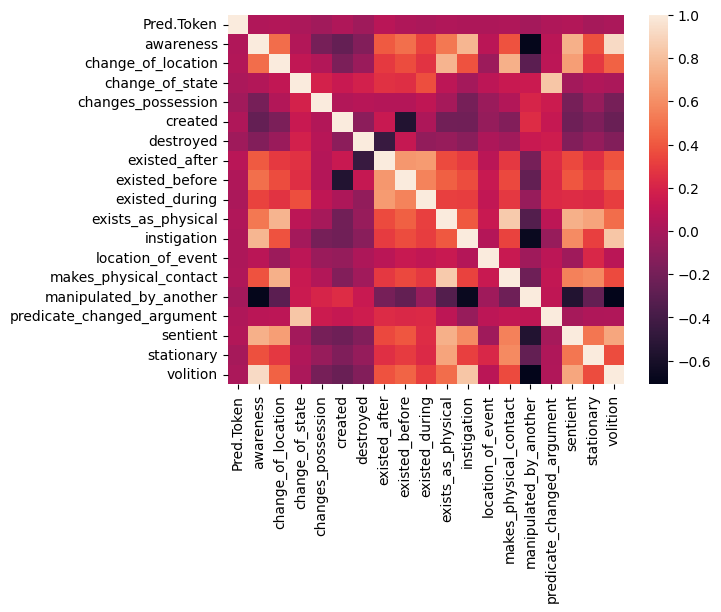

In [32]:
sns.heatmap(roles_wide.groupby(["Roleset", "Gram.Func"]).agg(np.mean).corr())

In [33]:
roles_wide_bin = roles_wide.copy(deep=True)
roles_wide_bin[properties_list] = (roles_wide[properties_list].to_numpy() > 3).astype(int)
roles_wide_bin

,Sentence.ID,Roleset,Pred.Token,Arg.Pos,Gram.Func,Split,awareness,change_of_location,change_of_state,changes_possession,...,predicate_changed_argument,sentient,stationary,volition,Sentence,Arg.Phrase,Arg.Stripped,Sentence.Stripped,Predicate,verb_sense
0,0003_21,impose.01,7,11:1,other,train,0,0,1,0,...,1,0,0,0,"In July , the Environmental Protection Agency ...",on virtually all uses of asbestos,on all uses,"In July , the Environmental Protection Agency ...",imposed,inflict.v.01
1,0003_21,impose.01,7,3:1,subj,train,1,0,0,0,...,0,0,0,1,"In July , the Environmental Protection Agency ...",the Environmental Protection Agency,the Environmental Protection Agency,"In July , the Environmental Protection Agency ...",imposed,inflict.v.01
2,0003_21,impose.01,7,8:1,obj,test,0,0,0,0,...,1,0,0,0,"In July , the Environmental Protection Agency ...",a gradual ban,a ban,"In July , the Environmental Protection Agency ...",imposed,inflict.v.01
3,0003_25,dump.01,1,0:1,subj,train,1,0,0,0,...,0,1,0,1,Workers dumped large burlap sacks of the impor...,Workers,Workers,"Workers dumped burlap sacks into a huge bin , ...",dumped,dump.v.01
4,0003_25,dump.01,1,2:2,obj,train,0,1,1,0,...,1,0,0,0,Workers dumped large burlap sacks of the impor...,large burlap sacks of the imported material,burlap sacks,"Workers dumped burlap sacks into a huge bin , ...",dumped,dump.v.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9733,2454_31,consider.01,2,3:1,other,train,1,0,0,0,...,0,1,0,1,They never considered themselves to be anythin...,themselves,themselves,They never considered themselves to be anything .,considered,see.v.05
9734,2454_31,consider.01,2,4:1,other,train,0,0,0,0,...,0,0,0,0,They never considered themselves to be anythin...,to be anything else,to be anything,They never considered themselves to be anything .,considered,see.v.05
9735,2454_7,shoot.06,16,13:1,subj,train,1,0,0,0,...,0,1,0,1,"As the crowd outside his home shouted `` ANC ,...",the old man,the man,"As the crowd outside his home shouted `` ANC ,...",shot,blast.v.07
9736,2454_7,shoot.06,16,17:1,obj,train,0,1,1,0,...,1,0,0,0,"As the crowd outside his home shouted `` ANC ,...",his fists,the fists,"As the crowd outside his home shouted `` ANC ,...",shot,blast.v.07


/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_88353/3018378619.py:1: FutureWarning: The operation <function mean at 0x1045954e0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  sns.heatmap(roles_wide_bin.groupby(["Roleset", "Gram.Func"]).agg(np.mean).corr())


<Axes: >

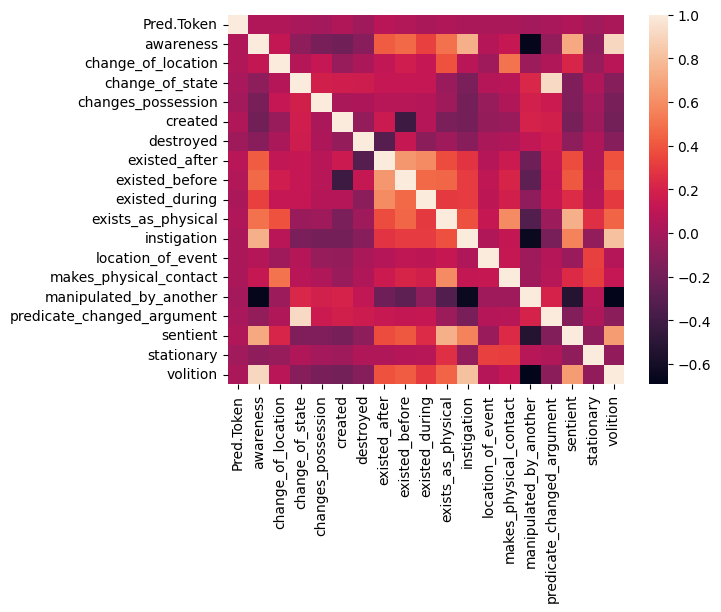

In [34]:
sns.heatmap(roles_wide_bin.groupby(["Roleset", "Gram.Func"]).agg(np.mean).corr())

In [35]:
F.kl_div(
    F.log_softmax(torch.Tensor(roles_wide["volition"])),
    F.log_softmax(torch.Tensor(roles_wide["sentient"])),
    reduction='batchmean', log_target=True
    )

/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_88353/1581654014.py:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  F.log_softmax(torch.Tensor(roles_wide["volition"])),
/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_88353/1581654014.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  F.log_softmax(torch.Tensor(roles_wide["sentient"])),


tensor(7.1467e-05)

In [36]:
kl_div = np.zeros((len(properties_list), len(properties_list)))
for i in range(len(properties_list)):
    for j in range(len(properties_list)):

        kl_div[i, j] = F.kl_div(
                            F.log_softmax(torch.Tensor(roles_wide[properties_list[i]])),
                            F.log_softmax(torch.Tensor(roles_wide[properties_list[j]])),
                            reduction='batchmean', log_target=True
                        )
        
kl_div.shape

/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_88353/3525478957.py:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  F.log_softmax(torch.Tensor(roles_wide[properties_list[i]])),
/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_88353/3525478957.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  F.log_softmax(torch.Tensor(roles_wide[properties_list[j]])),


(18, 18)

<Axes: >

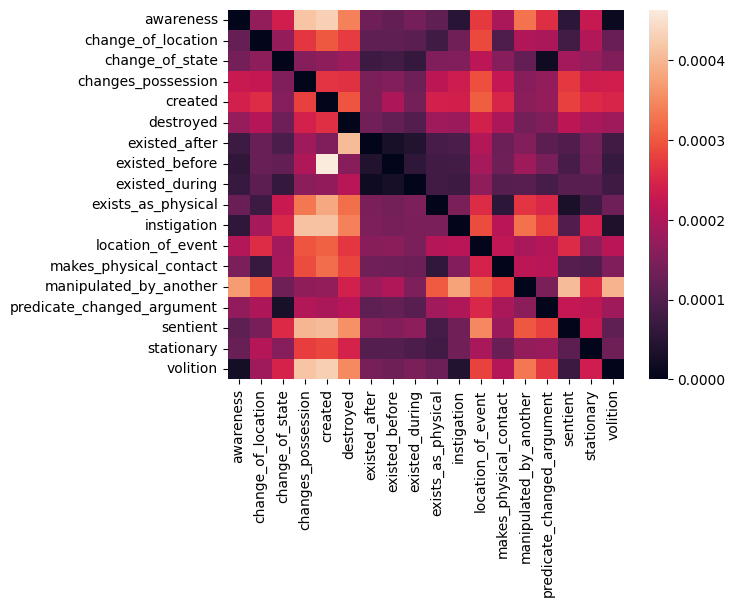

In [37]:
sns.heatmap(
    kl_div,
    xticklabels=properties_list, yticklabels=properties_list
)

In [38]:
from discrete_random_variable import entropy_conditional

conditional_entropies = np.zeros((len(properties_list), len(properties_list)))
for i in range(len(properties_list)):
    for j in range(len(properties_list)):

        conditional_entropies[i, j] = entropy_conditional(
            roles_wide[properties_list[i]],
            roles_wide[properties_list[j]])
        
conditional_entropies.shape

(18, 18)

<Axes: >

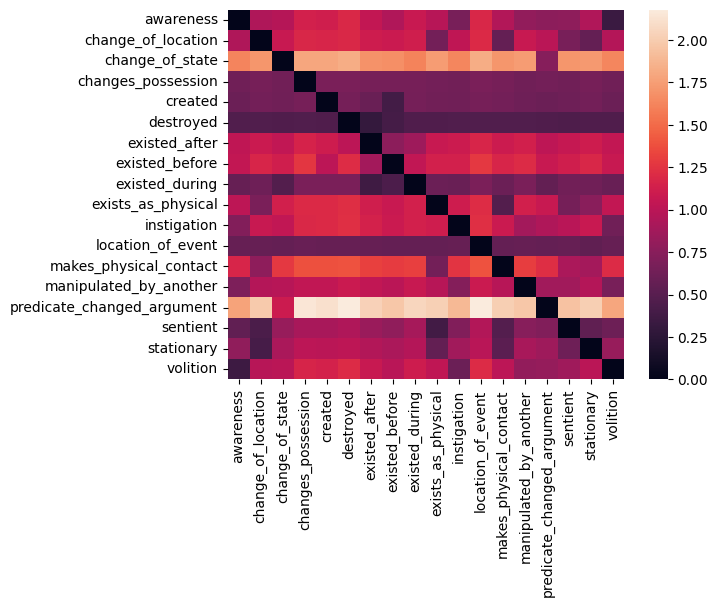

In [39]:
sns.heatmap(
    conditional_entropies,
    xticklabels=properties_list, yticklabels=properties_list
)